
# **Quickstart**

In [ ]:
import sys
sys.path.append('../')

In [ ]:
# imports and rendering options 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
def plot(results,year=2015):
    fig, ax = plt.subplots()
    t0=str(year)+'-01-01 00:00:15'
    t1=str(year)+'-02-01 00:00:00'
    ax.plot(p['T_amb'][t0:t1], label = 'T_amb')
    ax.plot(results['states'][t0:t1], label = list(results['states'].columns))#['T_bldg [°C]'])
    ax.plot(results['control'][t0:t1], label = 'T_hvac_sup [°C]')
    
    ax1 = ax.twinx()
    ax1.plot(results['costs']['Qdot_th'][t0:t1]/1000, label = 'Qdot_th', color = 'black')
    #ax1.plot(Qdot_sol/1000, color='y', label = 'Qdot_sol [kW]')
    
    ax.set_ylabel('Temperature in °C')
    ax1.set_ylabel('Thermal heat pump power [kW]')
    fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5)
    
    print('Qdot_th [kWh]:',sum(results['costs']['Qdot_th'][t0:t1]/1000/(3600/timestep)))

## 1.  Load **building parameters** and choose a **calculation method**.

A building model can be defined by its geometry (e.g. floor-area, room-height, window areas and directions) and  
it's material properties (specific heat-transfer coefficients, thermal capacities, g-value of the windows).  
Three example buildings can be found in the data/buildings directory.
The calculation defines how many temperature (states) will be calculated.  
Available calculation methods are: 2R2C, 4R3C, 5R4C. 

In [ ]:
import src.models.model_buildings as model_buildings

# load example building data
from data.buildings.sfh_1919_1948 import sfh_1919_1948_0_soc as building

# Initialize the building model
bldg_model = model_buildings.Building(params    = building, # More example buildings can be found in data/buildings/.
                                      mdot_hp   = 0.25,          # Massflow of the heat supply system. [kg/s]
                                      method    = '7R5C',        # For available calculation methods see: model_buildings.py.
                                      verbose   = False)

#bldg_model.params # print the building parameters

## 2. Define a **heat generation system**. 

Two different heat pump models are implemented. See model_hvac for details.

In [ ]:
import src.models.model_hvac as model_hvac

# Initalize the heat pump model, 
# set verbose to True, to generate a performance graph of the HP
hp_model = model_hvac.Heatpump_AW(mdot_HP = 0.25, verbose = False)

## 3. Generate **disturbance** profiles.

The disturbances by weather, internal- and solar gains can be generated as pandas dataframes:

In [ ]:
from src.disturbances import generate_disturbances
year = 2016
p_hourly = generate_disturbances(bldg_model,year, repo_filepath='..')#[0:168]


## 4. Set up the **simulator**.

Define the timestep, and pass the building_model and the hvac_model to the Simulator.

In [ ]:
import src.simulator as simulator
from importlib import reload
reload(simulator)


# define timestep
timestep = 900 #s
p = p_hourly.resample(f'{timestep}s').ffill() # resample disturbance

Simulator = simulator.Model_simulator(bldg_model = bldg_model,
                                      hp_model   = hp_model,
                                      timestep   = timestep)

# Get available state keys from building_model
state_keys = bldg_model.state_keys
#print(state_keys)

# Setup initial state vector
x_init = {key : 20 for key in state_keys} # here all inital states are set to 20 °C

## 5. **One step** simulation.

For a one step integration, you have to define the initial values of the corrent timestep for the temperature sates

In [ ]:
# Set the control variable
uk = 20  # T_hp_sup [°C]

# Either manually create the disturbance dict or choose one timestep (rand_int) of the previously generated disturbance dataframe.
#pk = {"T_amb" : 20,        # Ambient temperature [°C]
#      "Qdot_gains" : 0,}   # Internal and solar gains [W]

rand_int = 35
pk = p.iloc[rand_int].to_dict()

Simulator.get_next_state(x_init = x_init, uk = uk, pk = pk)

{'state': {'T_room': 19.393263917477434,
  'T_surf_wall': 19.674758146498817,
  'T_op': 19.480284061594105,
  'T_mass': 19.79916377057464,
  'T_surf_floor': 19.713336277652676,
  'T_hp_ret': 19.966129418417232,
  'T_surf': 19.683331064533007},
 'controls': 20,
 'parameters': {'T_amb': 2.9,
  'Qdot_gains': 1046.9624204329082,
  'Qdot_sol': 115.2624204329081,
  'Qdot_int': 931.7},
 'cost': {'P_el': 0.45912681656946314,
  'E_el': 0.11478170414236578,
  'COP': 5.6367742000000005,
  'Qdot_th': 2.5879941941668827,
  'dev_neg_sum': 0.07274281503827842,
  'dev_neg_max': 0.6067360825225663,
  'dev_pos_sum': 0.0,
  'dev_pos_max': 0.0}}

In [ ]:
x_init

{'T_room': 20,
 'T_surf_wall': 20,
 'T_op': 20,
 'T_mass': 20,
 'T_surf_floor': 20,
 'T_hp_ret': 20}

## 6. **Run multi step simulation**.

In [ ]:
# PID controller
import pandas as pd
SCENARIO_MODE = False
csv_name = 'results/I4B_simulation_pid_'+str(year)+'_'+str(SCENARIO_MODE)+'.csv'

kp, ki, kd = 7.2, 1.2, 24000
results_pid = Simulator.simulate(x_init=x_init, T_room_set=20, p=p, SCENARIO_MODE = SCENARIO_MODE, ctrl_method='pid', KP = kp, KI = ki, KD = kd)
result_df = pd.concat(results_pid.values(), axis=1, keys=results_pid.keys())
result_df.columns = result_df.columns.droplevel(0)
result_df = result_df.dropna()
result_df.reset_index(inplace=True)
# Rename the 'index' column to 'datetime'
result_df = result_df.rename(columns={'index': 'datetime'})

result_df.to_csv(csv_name, index=False)

# Heatingcurve controller
results_hc = Simulator.simulate(x_init=x_init, T_room_set=20, p=p, ctrl_method='heatcurve')
result_df = pd.concat(results_hc.values(), axis=1, keys=results_hc.keys())
result_df.to_csv('results/I4B_simulation_2015_hc.csv', index=True)


# Evaluate results

Qdot_th [kWh]: 10838.681177244842


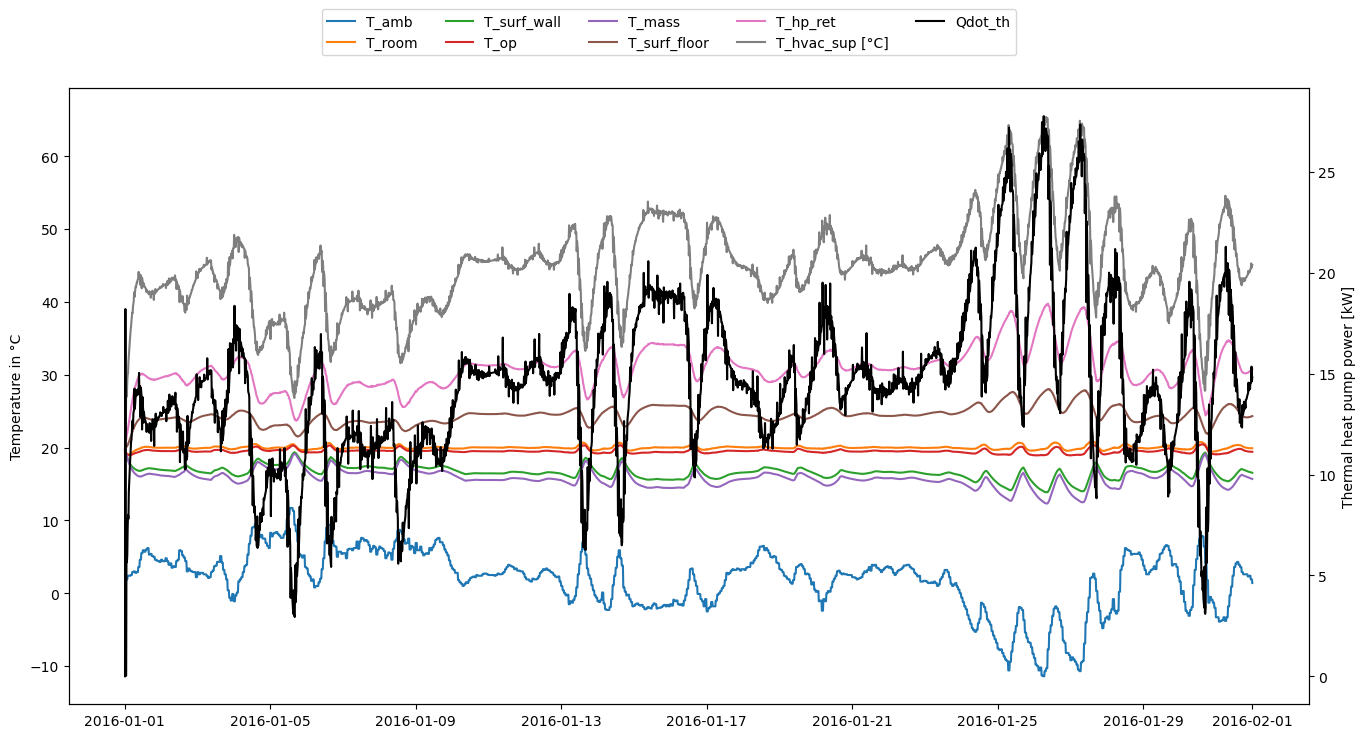

In [ ]:
plot(results_pid,year)

Qdot_th [kWh]: 10198.71082868992


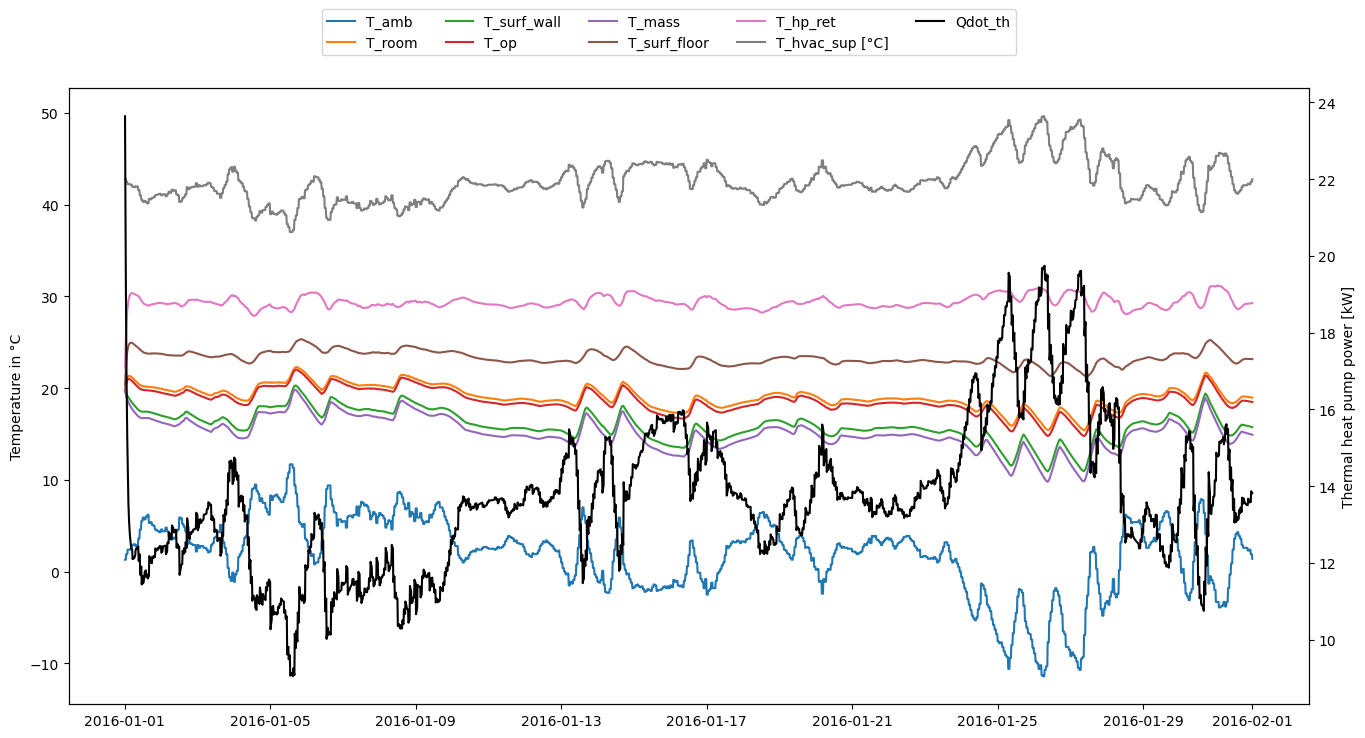

In [ ]:
plot(results_hc,year)